In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import PIL
import pathlib
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# fetch data
path = '../abstract_art_512'
data_dir = pathlib.Path(path)

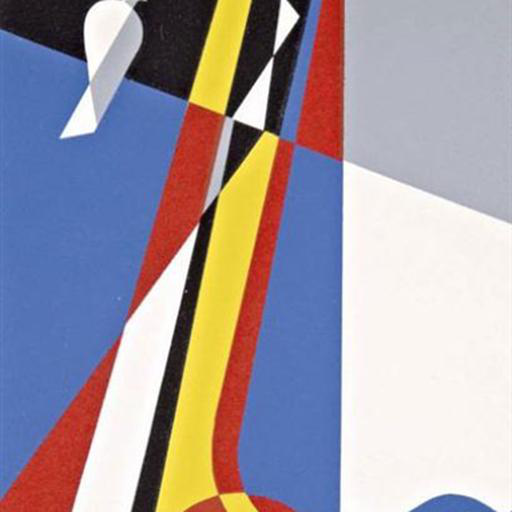

In [3]:
# visualize one image
test_img = list(data_dir.glob('abstract_yves-laloy_7236.jpg'))
PIL.Image.open(str(test_img[0]))

In [8]:
# image read parameters
seed = 1337
batch_size = 32
img_height = 512
img_width = 512

In [9]:
# read images as a tf object
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    labels=None,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 8145 files belonging to 1 classes.
Using 6516 files for training.


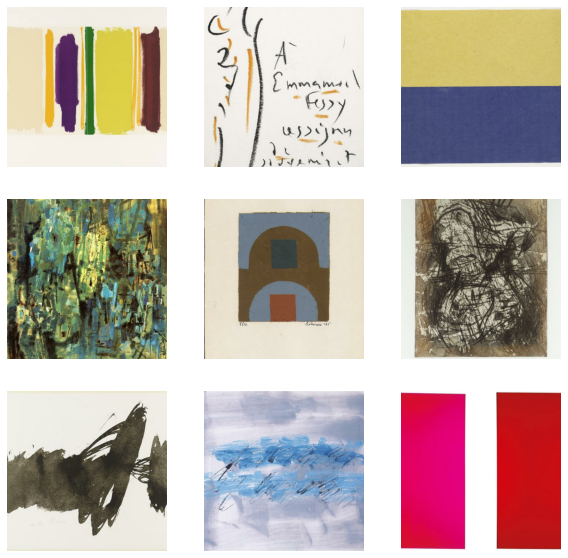

In [21]:
# visualize + randomly selected images
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.axis('off')

In [31]:
# standardize data to [-1, 1]
normalization = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)
normalized_ds = train_ds.map(lambda x: (normalization(x)))

In [35]:
# validate the transformation
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

-1.0 1.0
